## 导出特征向量

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *


In [ ]:
# 获得当前目录
current_dir = os.getcwd()
np.random.seed(2018)

In [ ]:
# 定义导出特征方法
def export_feature(MODEL, image_size, batch_size, preprocess_input=None):
    # 定义输入的tensor
    input_tensor = Input((image_size[0], image_size[1], 3))
    x = input_tensor
    # 预处理输入
    if preprocess_input:
        x = Lambda(preprocess_input)(x)
        
    # 定义基本模型，以imagenet为权重，不保留顶层的3个全连接网络
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False, pooling='avg')
    
    # 添加全局平均池化层
    model = base_model.output
    model = GlobalAveragePooling2D()(model)
        
    # 构建图像预处理
    gen = ImageDataGenerator()
    # 创建训练集，指定image_size，不混淆数据，指定一批数据的大小
    train_generator = gen.flow_from_directory(current_dir + '/data/train', image_size, shuffle=False, 
                                              batch_size=batch_size)
    # 创建测试集，指定image_size，不混淆数据，指定一批数据的大小，不返回标签
    test_generator = gen.flow_from_directory(current_dir + "/data/test", image_size, shuffle=False, 
                                             batch_size=batch_size, class_mode=None)
    # 预测生成器，从数据集中获取样本
    train_feature = model.predict_generator(train_generator, train_generator.samples, verbose=1)
    test_feature = model.predict_generator(test_generator, test_generator.samples, verbose=1)
    # 保存对应名称训练后的模型
    with h5py.File("feature_%s.h5"%base_model.name) as h:
        h.create_dataset("train", data=train_feature)
        h.create_dataset("test", data=test_feature)
        h.create_dataset("label", data=train_generator.classes)

In [ ]:
export_feature(ResNet50, (224, 224), batch_size=16)

In [ ]:
export_feature(InceptionV3, (299, 299), batch_size=16, preprocess_input=inception_v3.preprocess_input)

In [ ]:
export_feature(Xception, (299, 299), batch_size=16, preprocess_input=xception.preprocess_input)

## 导入模型

In [2]:
X_train = []
X_test = []
# 聚合模型
for filename in ["feature_resnet50.h5", "feature_xception.h5", "feature_inception_v3.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

/Users/kevin/anaconda2/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 构建模型

In [3]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Using TensorFlow backend.


## 模型可视化

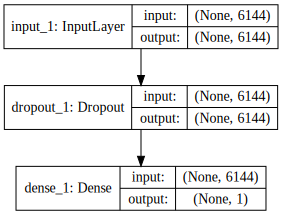

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## 训练

每次epoch保存较好的模型权重进行下一步的训练

In [5]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath="fine_weight.h5", monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min',
                             save_weights_only=True)

model.fit(X_train, y_train, batch_size=128, epochs=20, validation_split=0.2, shuffle=True, callbacks=[checkpoint])
model.save_weights("merge_fine_weight.h5")

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 1s 41us/step - loss: 0.0810 - acc: 0.9722 - val_loss: 0.0185 - val_acc: 0.9956

Epoch 00001: val_loss improved from inf to 0.01851, saving model to fine_weight.h5
Epoch 2/20
20000/20000 [==============================] - 1s 35us/step - loss: 0.0235 - acc: 0.9932 - val_loss: 0.0144 - val_acc: 0.9950

Epoch 00002: val_loss improved from 0.01851 to 0.01441, saving model to fine_weight.h5
Epoch 3/20
20000/20000 [==============================] - 1s 35us/step - loss: 0.0178 - acc: 0.9949 - val_loss: 0.0144 - val_acc: 0.9946

Epoch 00003: val_loss improved from 0.01441 to 0.01439, saving model to fine_weight.h5
Epoch 4/20
20000/20000 [==============================] - 1s 35us/step - loss: 0.0162 - acc: 0.9950 - val_loss: 0.0111 - val_acc: 0.9970

Epoch 00004: val_loss improved from 0.01439 to 0.01109, saving model to fine_weight.h5
Epoch 5/20
20000/20000 [==============================]

In [6]:
# 模型预测
model.load_weights('merge_fine_weight.h5')
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

12500/12500 [==============================] - 0s 18us/step


## 测试集预测

In [7]:

df = pd.read_csv("sample_submission.csv")

image_size = (224, 224)
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory(current_dir + "/data/test", image_size, shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/') + 1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('merged_pred.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.


/Users/kevin/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


0.03936

Found 12500 images belonging to 1 classes.


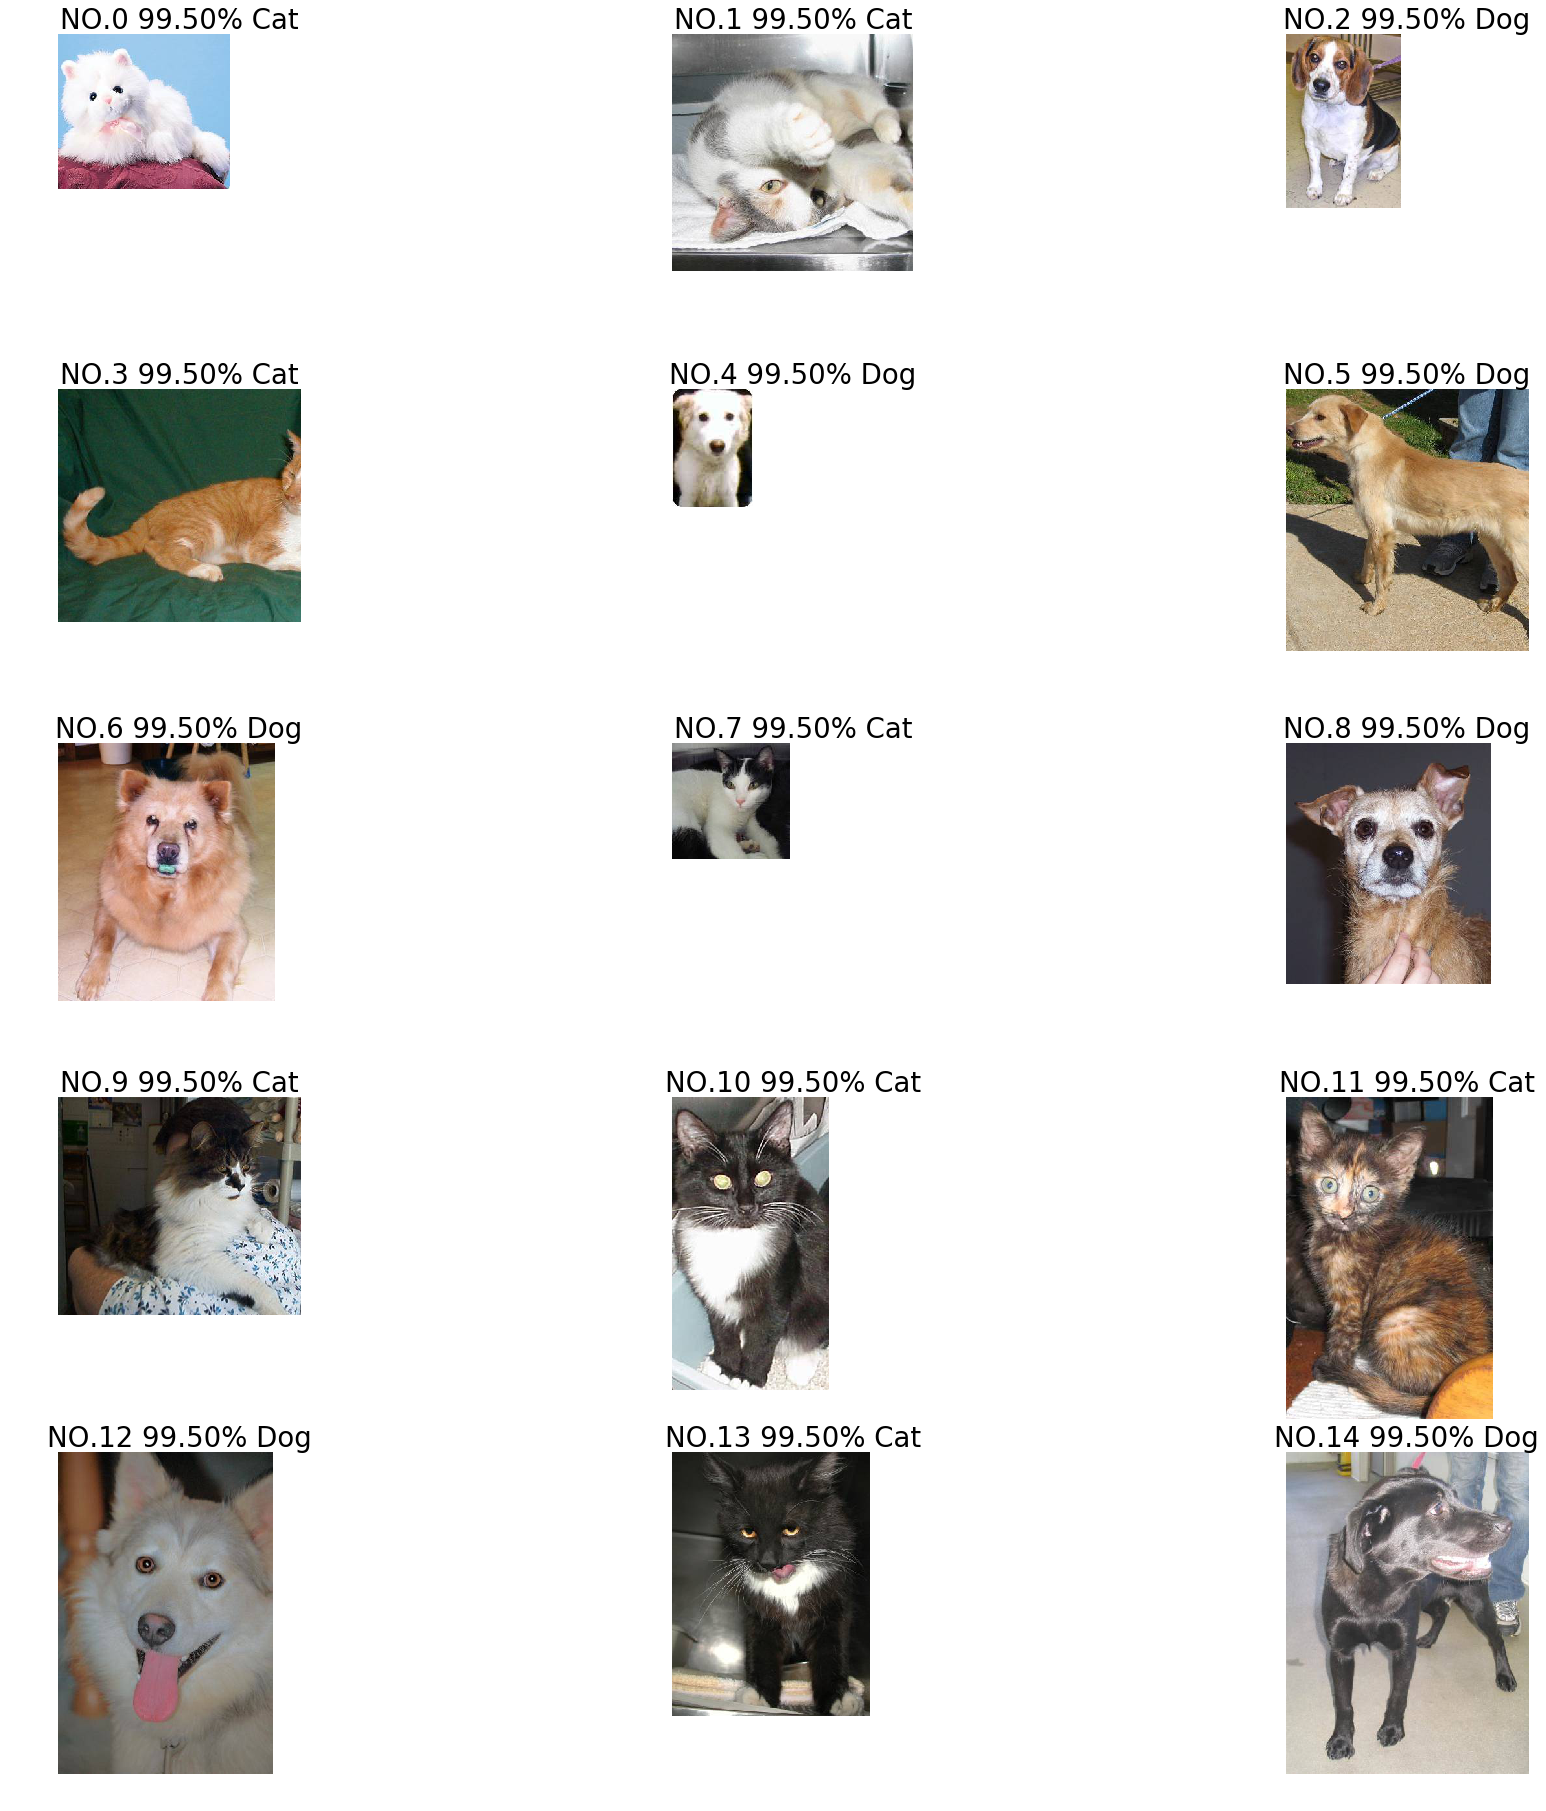

In [10]:
import matplotlib.pyplot as plt
from PIL import Image
i_dim = 3
j_dim = 5
np.random.seed(2018)
indices = np.random.randint(12500,size=i_dim*j_dim)
figure,ax=plt.subplots(j_dim,i_dim,sharex=True,sharey=True)
plt.rc('figure',figsize=(32,32))
font_option={'size':23}
plt.rc('font',**font_option)
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory(current_dir + "/data/test/", shuffle=False)
figure.titlesize  = "large"
for j in range(j_dim):
    for i in range(i_dim):
        y_pred_index = indices[i_dim*j+i]
        img_file_name = current_dir + "/data/test/" + test_generator.filenames[y_pred_index]
        img = Image.open(img_file_name)
        ax[j][i].axis('off') # 关掉坐标轴为 off
        rate = float(y_pred[y_pred_index])
        if rate>0.5:
            ax[j][i].set_title('NO.{} {:.2%} Dog'.format(i_dim*j+i,rate)) # 图像题目
        else:
            ax[j][i].set_title('NO.{} {:.2%} Cat'.format(i_dim*j+i,1.-rate)) # 图像题目
        ax[j][i].imshow(img)
plt.subplots_adjust(wspace=0.1,hspace=0.1)
plt.savefig("pred_samples.png",dpi=200,bbox_inches="tight")